In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

In [30]:
#uncertainty qubits
uncertainty_qubits = 3

#parameters for distribution, WILL CHANGE FOR SITUATION
# parameters for considered random distribution
S = 1000 # initial spot price
vol = 0.2 # volatility of 40%
r = 0.04 # annual interest rate of 4%
T = 30 / 365 # 40 days to maturity  

# parameters for how we are modeling the distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu+sigma**2)
stddev = np.sqrt(variance)

#lowest and highest value considered for spot price
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

#This contructs an operator that will be used for Quantum Amplitude Estimation
#This is essentially the circuit A I talked about earlier.
uncertainty_model = LogNormalDistribution(
    uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)


In [46]:
x = uncertainty_model.values
y = uncertainty_model.probabilities

strike_price = 1020

c_value = 0.15

breakpoints = [low, strike_price] # the range
slopes = [-1,0] # different slopes of the piecewise function
offsets = [strike_price-low,0] #y-intercepts of the piecewise function
f_min = 0
f_max = strike_price - low
# Linear Amplitude Function implements a circuit a piecewise linear 
# function on qubit amplitudes
european_put_objective = LinearAmplitudeFunction(
    uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_value,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
european_put = european_put_objective.compose(uncertainty_model, front=True)
european_put.draw()

┌───────┐┌────┐
q349_0: ┤0      ├┤0   ├
        │       ││    │
q349_1: ┤1 P(X) ├┤1   ├
        │       ││    │
q349_2: ┤2      ├┤2   ├
        └───────┘│    │
  q350: ─────────┤3 F ├
                 │    │
a166_0: ─────────┤4   ├
                 │    │
a166_1: ─────────┤5   ├
                 │    │
a166_2: ─────────┤6   ├
                 └────┘

In [47]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = -sum(uncertainty_model.probabilities[x <= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.2429
exact delta value:   	-0.5129


In [48]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_put,
    objective_qubits=[uncertainty_qubits],
    post_processing=european_put_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)

In [49]:
result = ae.estimate(problem)

In [52]:
conf_int = np.array(result.confidence_interval_processed)

print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Estimated value:    	33.1181
Confidence interval:	[27.3324, 38.9038]


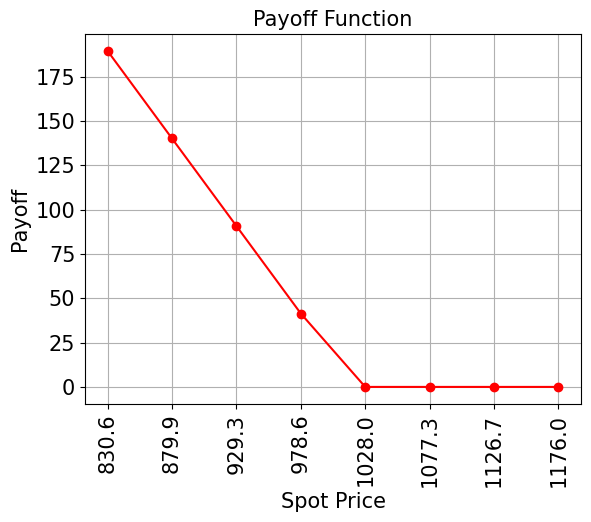

In [51]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, strike_price - x)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()